# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [1]:
import ipywidgets as widgets


class Seed:  # I know this looks dumb. not my fault
    random_seed = 1
    
print("Random Seed")
seed_input = widgets.IntText(
    value=Seed.random_seed,
    step=1,
    description='',
    disabled=False
)

output = widgets.Output()
display(seed_input, output)

def on_value_change(change):
    with output:
        Seed.random_seed = change['new']

seed_input.observe(on_value_change, names='value')

Random Seed


IntText(value=1)

Output()

In [2]:
# Dependencies
import pandas
from matplotlib import pyplot
from model.amm.amm import Asset, WorldState
from model.amm.omnipool_amm import OmnipoolAgent, OmniPool, OmnipoolTradeStrategies
import random
import math

# Experiments
from model import run, plot_utils, init_utils

random.seed(Seed.random_seed)
print(f'starting with random seed: {Seed.random_seed}')

assets = [
    Asset(name='LRNA', price=0.4),
    Asset(name='HDX', price=0.08),
    Asset(name='USD', price=1),
    Asset(name='R1', price=1000),
    Asset(name='R2', price=.001)
]
omnipool = (
    OmniPool(
        tvl_cap_usd=100000000,
        lrna_fee=0,
        asset_fee=0,
        preferred_stablecoin='USD'
    )
    .add_lrna_pool('HDX', 1000000)
    .add_lrna_pool('USD', 1000000)
    .add_lrna_pool('R1', 1000)
    .add_lrna_pool('R2', 1000000000)
)
agents = {
    "trader": OmnipoolAgent(
        name='trader',
        trade_strategy=OmnipoolTradeStrategies.random_swaps(amount = 1000)
    )
    .add_position('R1', 10000)
    .add_position('R2', 1000000000),
    
    "LP1": OmnipoolAgent(name='liquidity provider 1')
    .add_liquidity(omnipool, 'R1', 1000),
    
    "LP2": OmnipoolAgent(name='liquidity provider 2')
    .add_liquidity(omnipool, 'R2', 1000000000)
}

worldState = WorldState(
    exchange=omnipool,
    agents=agents
)

timesteps = 5000
state = {'WorldState': worldState}
config_dict = {
    'N': 1,  # number of monte carlo runs
    'T': range(timesteps),  # number of timesteps - 147439 is the length of uniswap_events
    'M': {'timesteps': [timesteps]},  # simulation parameters
}

pandas.options.mode.chained_assignment = None  # default='warn'
pandas.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()

starting with random seed: 1

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.55s


In [3]:
from model import processing
rdf, agent_df = processing.postprocessing(events, params_to_include=['withdraw_val', 'hold_val', 'pool_val'])


In [4]:
%matplotlib inline



## Analysis

[0]


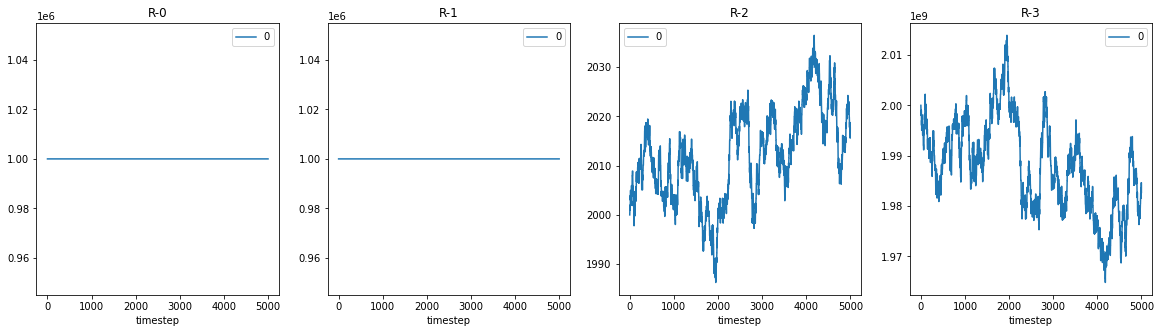

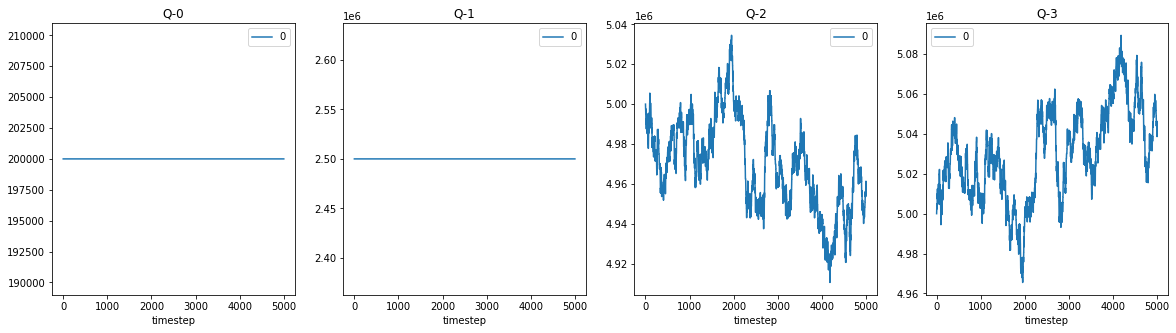

In [5]:
var_list = ['R', 'Q']
plot_utils.plot_vars(rdf, var_list)


[0]


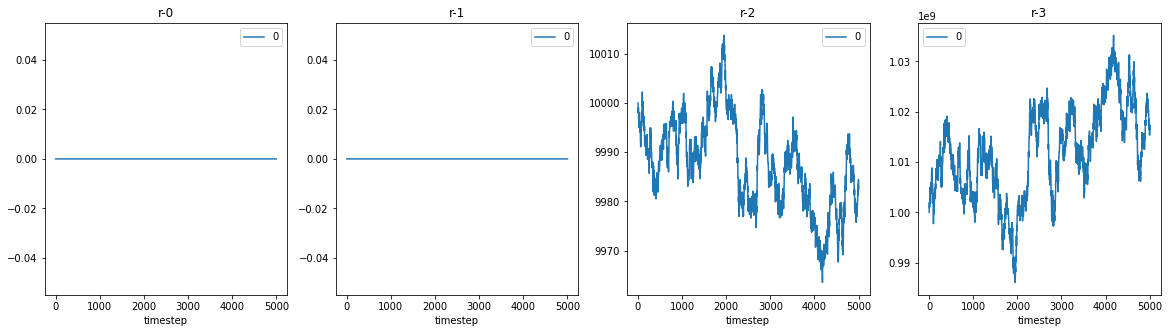

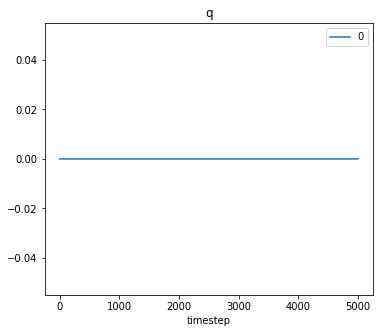

In [6]:
var_list = ['r', 'q']
trader_df = agent_df[agent_df['agent_label'] == 'trader']
plot_utils.plot_vars(trader_df, var_list)


In [7]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pandas.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [8]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d

merged_df['IL'] = merged_df.apply(lambda x: x['withdraw_val']/x['hold_val'] - 1 if x['hold_val'] else 0, axis=1)

In [9]:
merged_df[merged_df['agent_label'] == 'LP1'][['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','withdraw_val', 'hold_val','IL','pool_val']].head(20)


,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,withdraw_val,hold_val,IL,pool_val
1,1,LP1,0,200000.00,1000000,0,1000000,0,1000000,2500000.00,2500000.00,0.00,1252.70
4,2,LP1,0,200000.00,1000000,0,1000000,0,1000000,2497501.56,2497501.87,-0.00,1251.45
7,3,LP1,0,200000.00,1000000,0,1000000,0,1000000,2497501.56,2497501.87,-0.00,1251.45
10,4,LP1,0,200000.00,1000000,0,1000000,0,1000000,2497501.56,2497501.87,-0.00,1251.45
13,5,LP1,0,200000.00,1000000,0,1000000,0,1000000,2497501.56,2497501.87,-0.00,1251.45
16,6,LP1,0,200000.00,1000000,0,1000000,0,1000000,2495006.24,2495007.49,-0.00,1250.20
19,7,LP1,0,200000.00,1000000,0,1000000,0,1000000,2495006.24,2495007.49,-0.00,1250.20
22,8,LP1,0,200000.00,1000000,0,1000000,0,1000000,2497509.05,2497509.36,-0.00,1251.46
25,9,LP1,0,200000.00,1000000,0,1000000,0,1000000,2495013.72,2495014.97,-0.00,1250.21
28,10,LP1,0,200000.00,1000000,0,1000000,0,1000000,2497516.52,2497516.83,-0.00,1251.46


In [10]:
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
LP1_merged_df[['timestep', 'agent_label', 'q', 'Q-0' ,'P-2', 'B-0', 's-0', 'S-0', 'r-0', 'R-0', 'withdraw_val', 'hold_val','IL','pool_val']].head(50)
print(LP1_merged_df['P-2'].unique())
LP1_merged_df.head(50)

[2500.         2497.50187375 2495.00749001 ... 2461.48324716 2459.04261565
 2456.60561228]


,simulation,subset,run,substep,timestep,q,agent_label,r-0,r-1,r-2,...,S-0,S-1,S-2,S-3,P-0,P-1,P-2,P-3,pool_val,IL
1,0,0,1,1,1,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2500.00,0.00,1252.70,0.00
4,0,0,1,1,2,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2497.50,0.00,1251.45,-0.00
7,0,0,1,1,3,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2497.50,0.00,1251.45,-0.00
10,0,0,1,1,4,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2497.50,0.00,1251.45,-0.00
13,0,0,1,1,5,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2497.50,0.00,1251.45,-0.00
16,0,0,1,1,6,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2495.01,0.00,1250.20,-0.00
19,0,0,1,1,7,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2495.01,0.00,1250.20,-0.00
22,0,0,1,1,8,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2497.51,0.00,1251.46,-0.00
25,0,0,1,1,9,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2495.01,0.00,1250.21,-0.00
28,0,0,1,1,10,0,LP1,0,0,0.00,...,1000000,1000000,2000.00,2000000000.00,0.20,2.50,2497.52,0.00,1251.46,-0.00


## IL over time



[0]


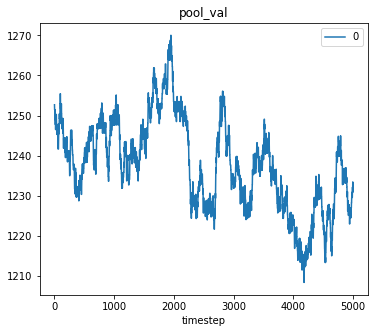

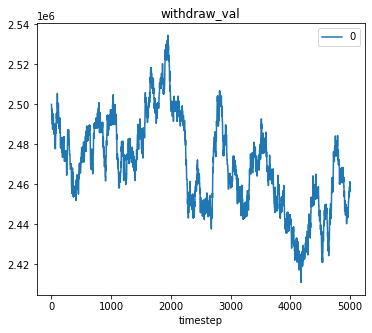

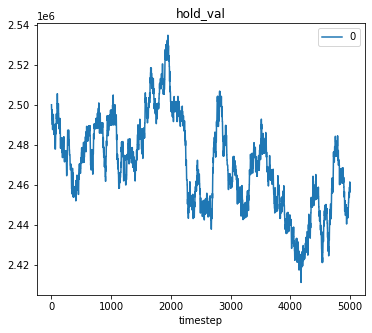

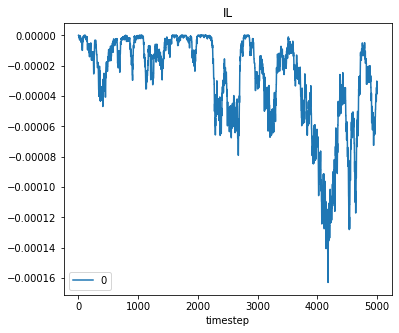

In [11]:
var_list = ['pool_val', 'withdraw_val', 'hold_val', 'IL']
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
plot_utils.plot_vars(LP1_merged_df, var_list)

## IL as a function of price movement

### Theory

On a price move from $p_i^Q \to k p_i^Q$, LP is entitled to $k\frac{\sqrt{k}}{k+1}$ of the *original value* of the matched pool.
$$
Val_{hold} = k p_i^Q R_i\\
Val_{pool} = \frac{\sqrt{k}k}{k+1} 2Q_i = \left(\frac{2\sqrt{k}k}{k+1}\right) p_i^Q R_i
$$

### $Val_{hold}$

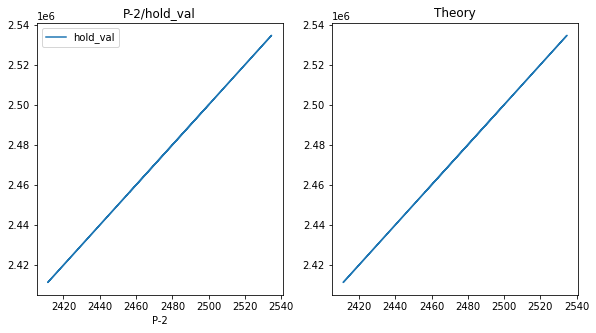

In [12]:
def val_hold_func(P, R):
    return P * R

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-2/IL')
#LP1_merged_df[['IL','P-2']].astype(float).plot(ax=ax, y=['IL'], x='P-2', label=[])
ax = pyplot.subplot(131, title='P-2/hold_val')
LP1_merged_df[['hold_val','P-2']].astype(float).plot(ax=ax, y=['hold_val'], x='P-2', label=[])

ax2 = pyplot.subplot(132, title='Theory')
x = LP1_merged_df['P-2'].tolist()
y = LP1_merged_df.apply(lambda x: val_hold_func(x['P-2'], agents['LP1'].s('R1')), axis=1)
ax2.plot(x,y)

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-2'].tolist()
#y = LP1_merged_df['P-2'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### $Val_{Pool}$

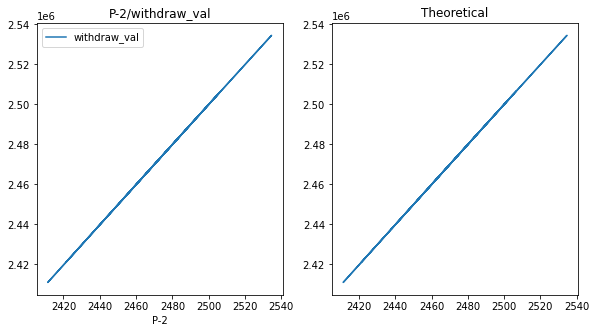

In [13]:
import math
def val_pool_func(P, P_init, R):
    k = P/P_init
    return 2 * k * math.sqrt(k) / (k + 1) * P_init * R

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-2/IL')
#LP1_merged_df[['IL','P-2']].astype(float).plot(ax=ax, y=['IL'], x='P-2', label=[])
ax = pyplot.subplot(131, title='P-2/withdraw_val')
LP1_merged_df[['withdraw_val','P-2']].astype(float).plot(ax=ax, y=['withdraw_val'], x='P-2', label=[])

ax2 = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-2'].tolist()
y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-2'], omnipool.P('R1'), agents['LP1'].s('R1')), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-2'], initial_values['P'][0], x['R-0']), axis=1)
ax2.plot(x, y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-2'].tolist()
#y = LP1_merged_df['P-2'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### Impermanent Loss

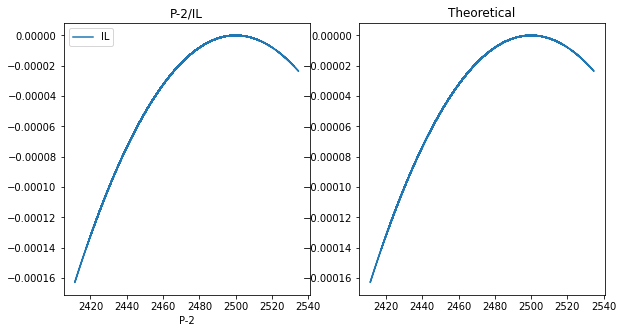

In [14]:
def IL_func(P, P_init, R):
    return val_pool_func(P, P_init, R)/val_hold_func(P, R) - 1

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-2/IL')
#LP1_merged_df[['IL','P-2']].astype(float).plot(ax=ax, y=['IL'], x='P-2', label=[])
ax = pyplot.subplot(131, title='P-2/IL')
LP1_merged_df[['IL','P-2']].astype(float).plot(ax=ax, y=['IL'], x='P-2', label=[])

ax2 = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-2'].tolist()
y = LP1_merged_df.apply(lambda x: IL_func(x['P-2'], omnipool.P('R1'), agents['LP1'].s('R1')), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-2'], initial_values['P'][0], x['R-0']), axis=1)
ax2.plot(x, y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-2'].tolist()
#y = LP1_merged_df['P-2'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

In [15]:
LP1_merged_df[['withdraw_val', 'hold_val', 'R-0', 's-0', 'S-0', 'B-0', 'P-2', 'P-2']].tail()

,withdraw_val,hold_val,R-0,s-0,S-0,B-0,P-2,P-2
14986,2456347.53,2456442.38,1000000,0,1000000,1000000,2456.44,2456.44
14989,2458879.24,2458963.44,1000000,0,1000000,1000000,2458.96,2458.96
14992,2461409.07,2461483.25,1000000,0,1000000,1000000,2461.48,2461.48
14995,2458958.74,2459042.62,1000000,0,1000000,1000000,2459.04,2459.04
14998,2456511.46,2456605.61,1000000,0,1000000,1000000,2456.61,2456.61
